# **Social Media Recommendation Agent Using Deep Q-Networks (DQN)**

Initializing post catalog with expanded topics and topic-aware media URLs...
Catalog contains 800 posts across 30 topics and languages: ['English', 'Hindi', 'Telugu', 'Kannada']

Training agent (quick demo — increase episodes for stronger policy)...
Episode 30/1000 avg last30: 6.608
Episode 60/1000 avg last30: 6.609
Episode 90/1000 avg last30: 6.462
Episode 120/1000 avg last30: 6.188
Episode 150/1000 avg last30: 6.172
Episode 180/1000 avg last30: 6.816
Episode 210/1000 avg last30: 6.404
Episode 240/1000 avg last30: 6.782
Episode 270/1000 avg last30: 6.376
Episode 300/1000 avg last30: 6.391
Episode 330/1000 avg last30: 6.949
Episode 360/1000 avg last30: 7.579
Episode 390/1000 avg last30: 6.356
Episode 420/1000 avg last30: 6.880
Episode 450/1000 avg last30: 6.490
Episode 480/1000 avg last30: 6.958
Episode 510/1000 avg last30: 6.843
Episode 540/1000 avg last30: 5.515
Episode 570/1000 avg last30: 6.741
Episode 600/1000 avg last30: 6.714
Episode 630/1000 avg last30: 6.417
Episode 660/1000 a

Would you like to provide initial preferences? (y/N):  n


No initial preferences provided — simulating automatic cold-start.

--- Showing a short Instagram-style feed (session) ---

--------------------------------------------------------------------------------
POST ID: 40  | Creator: @creator66
[VIDEO] URL: https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/BigBuckBunny.mp4?post=40&topic=DIY
Video detail/test: public sample mp4 (BigBuckBunny) 720p
Title: DIY — How-to
Topic: DIY  | Language: Telugu  | Popularity: 0.29
Caption: A short post about DIY with insights and examples. #learn #DIY

[Why recommended — technical explanation]
  similarity: 0.007215792778879404
  language_match: False
  friend_match_fraction: 0.0
  popularity: 0.29
  repetition_penalty_applied: False
Final Reward (this action): 0.000
--------------------------------------------------------------------------------



Your action? [l = like, s = skip, v = view long, q = quit session] (default skip):  n


Top inferred topics for you now (approx):
  sports (score 4.13)
  education (score 3.58)
  travel (score 2.88)
  health (score 2.74)
  finance (score 2.36)
--------------------------------------------------------------------------------
POST ID: 449  | Creator: @creator77
[IMAGE] URL: https://via.placeholder.com/640x640.png?text=food+post449
Image detail/test: 640x640 placeholder (auto-generated)
Title: food — Explained
Topic: food  | Language: Telugu  | Popularity: 0.47
Caption: A short post about food with insights and examples. #learn #food

[Why recommended — technical explanation]
  similarity: -0.09837574511766434
  language_match: False
  friend_match_fraction: 0.143
  popularity: 0.471
  repetition_penalty_applied: False
Final Reward (this action): 0.000
--------------------------------------------------------------------------------



Your action? [l = like, s = skip, v = view long, q = quit session] (default skip):  l


You liked the post — user profile updated.
Top inferred topics for you now (approx):
  sports (score 3.75)
  education (score 3.25)
  friends (score 3.16)
  travel (score 2.78)
  movies (score 2.40)
--------------------------------------------------------------------------------
POST ID: 449  | Creator: @creator77
[IMAGE] URL: https://via.placeholder.com/640x640.png?text=food+post449
Image detail/test: 640x640 placeholder (auto-generated)
Title: food — Explained
Topic: food  | Language: Telugu  | Popularity: 0.47
Caption: A short post about food with insights and examples. #learn #food

[Why recommended — technical explanation]
  similarity: 0.2297850400209427
  language_match: False
  friend_match_fraction: 0.143
  popularity: 0.471
  repetition_penalty_applied: True
Final Reward (this action): -0.600
--------------------------------------------------------------------------------



Your action? [l = like, s = skip, v = view long, q = quit session] (default skip):  q


Ending session early.
Model saved to models/dqn_socialrec_instagram.pth; training rewards saved to training_rewards_instagram.csv


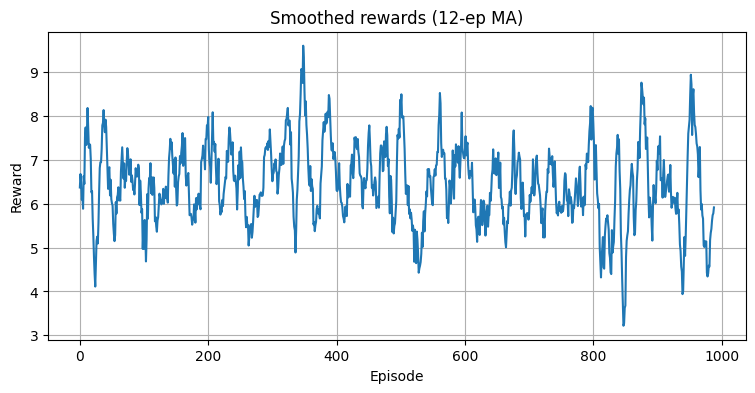

In [2]:

# Import libraries
import math, random, time, os, json, urllib.parse
from collections import deque, namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import textwrap


# Helper:  print Instagram-style post
def print_instagram_post(post, explain, reward):
    # human-friendly (feed) block
    print("-" * 80)
    print(f"POST ID: {post['post_id']}  | Creator: @{post['creator']}")
    # Show media type & URL
    if post.get("media_type") == "video":
        print(f"[VIDEO] URL: {post['media_url']}")
        # optional duration or extra text
        print(f"Video detail/test: {post.get('video_detail','sample mp4, public sample video')}")
    else:
        print(f"[IMAGE] URL: {post['media_url']}")
        print(f"Image detail/test: {post.get('image_detail','640x640 placeholder, auto-generated')}")
    print(f"Title: {post['title']}")
    print(f"Topic: {post['topic']}  | Language: {post['language']}  | Popularity: {post['popularity']:.2f}")
    # caption (truncate)
    caption = post['caption']
    if len(caption) > 140:
        caption = caption[:137] + "..."
    print("Caption:", caption)
    # technical explainability under a folded section
    print("\n[Why recommended — technical explanation]")
    for k, v in explain.items():
        print(f"  {k}: {v}")
    print(f"Final Reward (this action): {reward:.3f}")
    print("-" * 80 + "\n")

# Post  Generator (30 topics by default)
DEFAULT_TOPICS = [
    "love","friends","student","university","sports","music","travel","food","fashion",
    "technology","science","movies","fitness","health","education","parenting","finance",
    "productivity","art","photography","gaming","DIY","politics","news","memes","pets",
    "nature","business","startups","history"
]

# public sample video (stable Google-hosted sample)
SAMPLE_VIDEO_URL = "https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/BigBuckBunny.mp4"

def make_post_catalog(n_posts=800, content_dim=24, topics=None, n_langs=4, seed=42):
    random.seed(seed); np.random.seed(seed)
    if topics is None:
        topics = DEFAULT_TOPICS
    n_topics = len(topics)
    posts = []
    topic_names = topics
    # languages (short list)
    lang_names = ["English", "Hindi", "Telugu", "Kannada"][:n_langs]
    n_creators = max(40, n_posts//8)
    base_embeddings = np.random.normal(scale=0.6, size=(n_posts, content_dim)).astype(np.float32)
    topic_vectors = np.random.normal(scale=0.5, size=(n_topics, content_dim)).astype(np.float32)

    # Decide which topics are more likely to be video (you can change this set)
    video_like_topics = set([
        "sports","music","movies","fitness","travel","gaming","news","education","DIY","photography"
    ])

    for pid in range(n_posts):
        topic = random.randint(0, n_topics-1)
        lang = random.randint(0, n_langs-1)
        creator = f"creator{random.randint(1, n_creators)}"
        # synthetic caption and title
        title = f"{topic_names[topic]} — {random.choice(['Explained','Tips','Best Practices','Fun Fact','How-to'])}"
        caption = f"A short post about {topic_names[topic]} with insights and examples. #learn #{topic_names[topic]}"
        # create topic-safe label for URL text (encode)
        topic_label = urllib.parse.quote_plus(topic_names[topic])
        # choose media type by topic (probabilistic)
        is_video = (topic_names[topic] in video_like_topics) and (random.random() < 0.62)
        if is_video:
            # use a stable sample mp4 url (public). We also append a query param to indicate post id/topic (harmless)
            media_url = f"{SAMPLE_VIDEO_URL}?post={pid}&topic={topic_label}"
            media_type = "video"
        else:
            # use via.placeholder.com for images, text includes topic and post id; ensure URL-encoded
            media_url = f"https://via.placeholder.com/640x640.png?text={topic_label}+post{pid}"
            media_type = "image"

        emb = base_embeddings[pid] + topic_vectors[topic] + np.random.normal(scale=0.02, size=(content_dim,))
        emb = emb / (np.linalg.norm(emb) + 1e-9)
        popularity = float(np.clip(np.random.beta(2,8) * 1.5 + 0.05, 0.01, 2.0))
        post_dict = {
            "post_id": pid,
            "embedding": emb.astype(np.float32),
            "topic_id": topic,
            "topic": topic_names[topic],
            "language_id": lang,
            "language": lang_names[lang],
            "creator": creator,
            "title": title,
            "caption": caption,
            "popularity": popularity,
            # media fields
            "media_type": media_type,
            "media_url": media_url,
            "image_detail": "640x640 placeholder (auto-generated)" if media_type=="image" else None,
            "video_detail": "public sample mp4 (BigBuckBunny) 720p" if media_type=="video" else None
        }
        posts.append(post_dict)
    return posts, topic_names, lang_names

# Enhanced Environment with posts + users + social graph + explainability
class SocialInstagramEnv:
    def __init__(self, posts, content_dim=24, n_users=600, K=6, seed=1, frac_new_users=0.18):
        random.seed(seed); np.random.seed(seed)
        self.posts = posts
        self.n_posts = len(posts)
        self.content_dim = content_dim
        self.K = K
        self.n_users = n_users
        # user base embeddings: cluster by topics for realistic preferences
        self.users = np.random.normal(scale=0.5, size=(n_users, content_dim)).astype(np.float32)
        # create topic bias for users
        n_topics = max(1, max(p['topic_id'] for p in posts) + 1)
        topic_vectors = np.zeros((n_topics, content_dim), dtype=np.float32)
        for p in posts:
            topic_vectors[p['topic_id']] += p['embedding']
        # normalize topic vectors
        for i in range(n_topics):
            if np.linalg.norm(topic_vectors[i]) > 0:
                topic_vectors[i] /= np.linalg.norm(topic_vectors[i])
        user_topic_assign = np.random.randint(0, n_topics, size=n_users)
        for u in range(n_users):
            self.users[u] += 0.8 * topic_vectors[user_topic_assign[u]]
        # normalize
        self.users /= np.clip(np.linalg.norm(self.users, axis=1, keepdims=True), 1e-9, None)

        # language prefs (soft)
        self.n_langs = max(p['language_id'] for p in posts) + 1
        self.user_lang_pref = np.zeros((n_users, self.n_langs), dtype=np.float32)
        for u in range(n_users):
            p = np.random.dirichlet([1.0]*self.n_langs)
            self.user_lang_pref[u] = p

        # social graph (friends)
        self.friends = [set() for _ in range(n_users)]
        for u in range(n_users):
            for _ in range(3):
                v = (u + random.randint(1,30)) % n_users
                self.friends[u].add(v); self.friends[v].add(u)
            if random.random() < 0.06:
                v = random.randint(0, n_users-1)
                self.friends[u].add(v); self.friends[v].add(u)

        self.user_hist = [deque(maxlen=80) for _ in range(n_users)]
        self.user_interactions = np.zeros(n_users, dtype=np.int32)

        # cold-start flags
        new_count = int(frac_new_users * n_users)
        self.is_new_user = np.zeros(n_users, dtype=bool)
        new_users_idx = np.random.choice(n_users, size=new_count, replace=False)
        self.is_new_user[new_users_idx] = True

        # runtime state
        self.current_user = None
        self.current_candidates = None
        self.step_in_session = 0
        self.max_session_len = 8
        self.temperature = 1.0
        self.last_session_used_friend_init = False

    def reset(self, user_id=None, user_profile_input=None):
        """
        user_profile_input: optional dict with 'language' (int), 'topics' (list of topic indices)
        """
        if user_id is None:
            self.current_user = np.random.randint(0, self.n_users)
        else:
            self.current_user = int(user_id)
        u = self.current_user
        self.step_in_session = 0
        self.current_candidates = np.random.choice(self.n_posts, size=self.K, replace=False)
        self.last_session_used_friend_init = False

        # if user provided profile input (e.g., at signup), incorporate
        if user_profile_input:
            # language: if given, set a strong language preference
            if 'language' in user_profile_input:
                lang_idx = user_profile_input['language']
                pref = np.ones(self.n_langs) * 0.02
                if 0 <= lang_idx < self.n_langs:
                    pref[lang_idx] = 0.9
                self.user_lang_pref[u] = pref / np.sum(pref)
            # topics: adjust user embedding toward average of those topic embeddings
            if 'topics' in user_profile_input and len(user_profile_input['topics']) > 0:
                topic_embs = []
                for p in self.posts:
                    if p['topic_id'] in user_profile_input['topics']:
                        topic_embs.append(p['embedding'])
                if topic_embs:
                    avg = np.mean(np.stack(topic_embs, axis=0), axis=0)
                    alpha = 0.9  # strong onboarding preference
                    self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*avg)
                self.is_new_user[u] = False

        # friend-based cold-start if new and few interactions
        if (self.is_new_user[u] or self.user_interactions[u] < 2) and not user_profile_input:
            friends = list(self.friends[u])
            friend_embs = []
            for f in friends:
                if self.user_interactions[f] > 0:
                    friend_embs.append(self.users[f])
            if friend_embs:
                avg = np.mean(np.stack(friend_embs, axis=0), axis=0)
                alpha = 0.6
                self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*avg)
                self.last_session_used_friend_init = True

        return self._get_state()

    def _norm(self, v):
        n = np.linalg.norm(v)
        return v / (n + 1e-9)

    def _get_state(self):
        u = self.current_user
        u_emb = self.users[u]
        lang_pref = self.user_lang_pref[u]
        cand_embs = np.concatenate([self.posts[c]['embedding'] for c in self.current_candidates])
        pop = np.array([self.posts[c]['popularity'] for c in self.current_candidates], dtype=np.float32)
        hist = np.array([self.user_hist[self.current_user].count(int(cid)) for cid in self.current_candidates], dtype=np.float32)
        prog = np.array([self.step_in_session / max(1, self.max_session_len)], dtype=np.float32)
        state = np.concatenate([u_emb, lang_pref, cand_embs, pop, hist, prog]).astype(np.float32)
        return state

    def step(self, action, update_user_online=True):
        assert 0 <= action < self.K
        cid = int(self.current_candidates[action])
        post = self.posts[cid]
        u = self.current_user

        user_emb = self.users[u]
        content_emb = post['embedding']
        score = float(np.dot(user_emb, content_emb)) * (post['popularity']) / self.temperature

        # language match bonus
        user_top_lang = int(np.argmax(self.user_lang_pref[u]))
        content_lang = post['language_id']
        lang_bonus = 0.25 if user_top_lang == content_lang else 0.0

        p_raw = 1/(1+math.exp(-score))
        p_click = np.clip(p_raw * (1 + lang_bonus), 0.0, 0.999)

        clicked = np.random.rand() < p_click
        watch_prop = 0.0
        if clicked:
            # for video posts we can bias watch_prop a bit higher (users watch videos more if they match)
            beta_base = 2 + max(0, score)
            if post.get("media_type") == "video":
                beta_base += 0.6
            watch_prop = np.clip(np.random.beta(beta_base, 2), 0, 1)

        r_engage = 0.0
        if clicked:
            r_engage += 1.0
            if watch_prop > 0.5: r_engage += 1.0
            if watch_prop > 0.9: r_engage += 1.0
            r_engage += 0.12 * np.log1p(post['popularity'])

        rep_pen = -0.6 if cid in self.user_hist[u] else 0.0
        diversity_bonus = 0.25 if post['popularity'] < 0.2 else 0.0
        retention = 0.0
        if clicked and watch_prop > 0.65 and self.step_in_session >= 1:
            retention = 0.6

        reward = float(r_engage + retention + diversity_bonus + rep_pen)

        # explainability computations
        sim = float(np.dot(user_emb, content_emb))
        # friend-match: estimate how many friends interacted with similar topic
        friends = list(self.friends[u])
        friend_match = 0.0
        if friends:
            cnt = 0
            for f in friends:
                cnt += float(np.dot(self.users[f], content_emb) > 0.4)
            friend_match = cnt / max(1, len(friends))

        # update history & counts
        self.user_hist[u].append(cid)
        self.user_interactions[u] += 1

        # online user embedding update (EMA) to simulate learning
        if clicked and update_user_online:
            alpha = 0.12
            self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*content_emb)

        # popularity drift
        if clicked:
            post['popularity'] = float(np.clip(post['popularity'] + 0.02, 0.01, 2.0))

        # session advance
        self.step_in_session += 1
        done = (self.step_in_session >= self.max_session_len)
        if not done:
            replace_idx = np.random.randint(0, self.K)
            pool = list(set(range(self.n_posts)) - set(self.current_candidates))
            if random.random() < 0.14:
                top_idx = np.argsort([p['popularity'] for p in self.posts])[-80:]
                new_c = int(np.random.choice(top_idx))
            else:
                new_c = int(np.random.choice(pool))
            self.current_candidates[replace_idx] = new_c

        explain = {
            "similarity": sim,
            "language_match": bool(user_top_lang == content_lang),
            "friend_match_fraction": round(friend_match, 3),
            "popularity": round(post['popularity'], 3),
            "repetition_penalty_applied": bool(rep_pen < 0)
        }

        next_state = self._get_state() if not done else None
        info = {"clicked": clicked, "watch_prop": watch_prop, "post": post, "explain": explain, "used_friend_init": self.last_session_used_friend_init}
        return next_state, reward, done, info

    def action_space_n(self): return self.K
    def state_size(self): return self.content_dim + self.n_langs + self.K*self.content_dim + self.K + self.K + 1

# DQN 

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=15000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args): self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self): return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=224):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )
    def forward(self, x): return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, device='cpu'):
        self.device = device
        self.q_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.opt = optim.Adam(self.q_net.parameters(), lr=3.5e-4)
        self.replay = ReplayBuffer(15000)
        self.gamma = 0.98
        self.batch_size = 64
        self.update_target_every = 350
        self.steps = 0
        self.eps_start, self.eps_end, self.eps_decay = 1.0, 0.05, 9000

    def select_action(self, state, action_n, prefer_explore=False):
        eps = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps / self.eps_decay)
        if prefer_explore:
            eps = max(eps, 0.36)
        self.steps += 1
        if random.random() < eps:
            return random.randrange(action_n)
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            q = self.q_net(s).cpu().numpy()[0]
            return int(np.argmax(q))

    def push(self, *args): self.replay.push(*args)

    def update(self):
        if len(self.replay) < self.batch_size:
            return 0.0
        batch = self.replay.sample(self.batch_size)
        state = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=self.device)
        action = torch.tensor(batch.action, dtype=torch.long, device=self.device).unsqueeze(1)
        reward = torch.tensor(batch.reward, dtype=torch.float32, device=self.device).unsqueeze(1)
        nonfinal_next = [s for s,d in zip(batch.next_state, batch.done) if not d]
        if nonfinal_next:
            nonfinal_next = torch.tensor(np.stack(nonfinal_next), dtype=torch.float32, device=self.device)
        else:
            nonfinal_next = None
        q_vals = self.q_net(state).gather(1, action)
        next_vals = torch.zeros(self.batch_size, 1, device=self.device)
        if nonfinal_next is not None:
            next_q = self.target_net(nonfinal_next).max(1)[0].detach().unsqueeze(1)
            it = 0
            for i, done_flag in enumerate(batch.done):
                if not done_flag:
                    next_vals[i] = next_q[it]; it += 1
        expected = reward + self.gamma * next_vals
        loss = nn.functional.mse_loss(q_vals, expected)
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        if self.steps % self.update_target_every == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        return float(loss.detach().cpu().numpy())

# Training / evaluate / demo flow
def train_agent(env, agent, episodes=360):
    rewards, losses = [], []
    for ep in range(episodes):
        state = env.reset()
        prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
        ep_rew = 0.0; done = False
        while not done:
            a = agent.select_action(state, env.action_space_n(), prefer_explore=prefer_explore)
            next_s, r, done, info = env.step(a, update_user_online=True)
            agent.push(state, a, r, next_s, done)
            loss = agent.update()
            if loss is not None: losses.append(loss)
            state = next_s if next_s is not None else state
            ep_rew += r
        rewards.append(ep_rew)
        if (ep+1) % 30 == 0:
            print(f"Episode {ep+1}/{episodes} avg last30: {np.mean(rewards[-30:]):.3f}")
    return rewards, losses

def evaluate(env, agent, episodes=220):
    total=0.0; clicks=0; sessions=0; friend_init_sessions=0
    for _ in range(episodes):
        state = env.reset()
        if env.last_session_used_friend_init: friend_init_sessions += 1
        prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
        done=False; sess_rew=0.0
        while not done:
            a = agent.select_action(state, env.action_space_n(), prefer_explore=prefer_explore)
            next_s, r, done, info = env.step(a, update_user_online=True)
            state = next_s if next_s is not None else state
            sess_rew += r
            if info.get("clicked", False): clicks += 1
        total += sess_rew; sessions += 1
    return {"avg_reward": total/sessions, "clicks_per_session": clicks/sessions, "friend_init_sessions": friend_init_sessions}

# User-facing demo
def demo_user_flow(env, agent):
    print("\n--- DEMO: Provide optional initial preferences to help cold-start (press Enter to skip) ---")
    ask = input("Would you like to provide initial preferences? (y/N): ").strip().lower()
    user_provided_prefs = None
    if ask == 'y':
        lang_choice = input(f"Choose language (0..{env.n_langs-1}) or press Enter to skip: ").strip()
        topics_choice = input("Enter comma-separated topic indices (e.g., 0,2) or press Enter to skip: ").strip()
        prefs = {}
        if lang_choice != "":
            try:
                li = int(lang_choice)
                prefs['language'] = li
            except:
                print("Invalid language choice — skipping.")
        if topics_choice != "":
            try:
                topics = [int(x.strip()) for x in topics_choice.split(",") if x.strip()!='']
                prefs['topics'] = topics
            except:
                print("Invalid topics — skipping.")
        if prefs:
            user_provided_prefs = prefs
        # create a random user slot for the demo
        user_slot = random.randint(0, env.n_users-1)
        print(f"Using internal user id = {user_slot} with prefs: {user_provided_prefs}")
        state = env.reset(user_id=user_slot, user_profile_input=user_provided_prefs)
    else:
        print("No initial preferences provided — simulating automatic cold-start.")
        state = env.reset()

    # show a short feed (session)
    print("\n--- Showing a short Instagram-style feed (session) ---\n")
    steps = 6
    for step in range(steps):
        prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
        a = agent.select_action(state, env.action_space_n(), prefer_explore=prefer_explore)
        next_state, reward, done, info = env.step(a, update_user_online=True)
        post = info['post']
        explain = info['explain']
        # human + technical output
        print_instagram_post(post, explain, reward)
        # after printing, prompt simulated user action (like / skip / view long)
        action = input("Your action? [l = like, s = skip, v = view long, q = quit session] (default skip): ").strip().lower()
        if action == 'l':
            u = env.current_user
            env.users[u] = env._norm((1-0.25)*env.users[u] + 0.25*post['embedding'])
            print("You liked the post — user profile updated.")
        elif action == 'v':
            post['popularity'] = float(np.clip(post['popularity'] + 0.04, 0.01, 3.0))
            print("You viewed the post in detail (long watch).")
        elif action == 'q':
            print("Ending session early.")
            break
        # show delta in user preference approx by reporting the top-3 nearest topics before/after (approx)
        uid_cur = env.current_user
        topic_scores = {}
        for p in env.posts:
            t = p['topic']
            if t not in topic_scores: topic_scores[t] = 0.0
            topic_scores[t] += float(np.dot(env.users[uid_cur], p['embedding'])) * p['popularity']
        sorted_topics = sorted(topic_scores.items(), key=lambda x:-x[1])[:5]
        print("Top inferred topics for you now (approx):")
        for t, sc in sorted_topics:
            print(f"  {t} (score {sc:.2f})")
        if done:
            print("Session finished.\n")
            break
        state = next_state if next_state is not None else state

# Main
if __name__ == "__main__":
    print("Initializing post catalog with expanded topics and topic-aware media URLs...")
    posts, topic_names, lang_names = make_post_catalog(n_posts=800, content_dim=24, topics=None, n_langs=4, seed=101)
    print(f"Catalog contains {len(posts)} posts across {len(topic_names)} topics and languages: {lang_names}")

    env = SocialInstagramEnv(posts=posts, content_dim=24, n_users=800, K=6, seed=2025, frac_new_users=0.2)
    state_dim = env.state_size(); action_dim = env.action_space_n()
    agent = DQNAgent(state_dim, action_dim, device='cpu')

    print("\nTraining agent (quick demo — increase episodes for stronger policy)...")
    t0 = time.time()
    rewards, losses = train_agent(env, agent, episodes=1000)
    print("Training time:", time.time() - t0)

    print("\nEvaluating agent...")
    metrics = evaluate(env, agent, episodes=240)
    print("Evaluation metrics:", metrics)

    # show demo interactive user flow
    demo_user_flow(env, agent)

    # save
    os.makedirs("models", exist_ok=True)
    torch.save(agent.q_net.state_dict(), "models/dqn_socialrec_instagram.pth")
    pd.DataFrame({"episode": np.arange(1,len(rewards)+1), "reward": rewards}).to_csv("training_rewards_instagram.csv", index=False)
    print("Model saved to models/dqn_socialrec_instagram.pth; training rewards saved to training_rewards_instagram.csv")
    # plot smoothed rewards
    plt.figure(figsize=(9,4))
    plt.plot(np.convolve(rewards, np.ones(12)/12, mode='valid'))
    plt.title("Smoothed rewards (12-ep MA)"); plt.xlabel("Episode"); plt.ylabel("Reward"); plt.grid(True); plt.show()


# **Social Media Recommendation Agent Using Proximal Policy Optimization (PPO)**

Initializing post catalog...
Catalog contains 800 posts across 12 topics and languages: ['English', 'Hindi', 'Spanish', 'Other']

Training agent (A2C) — increase episodes for a stronger policy...
Episode 30/1000 avg last30 reward: 7.177 avg loss: 10.1077
Episode 60/1000 avg last30 reward: 6.289 avg loss: 6.0059
Episode 90/1000 avg last30 reward: 6.487 avg loss: 5.3245
Episode 120/1000 avg last30 reward: 6.242 avg loss: 4.2959
Episode 150/1000 avg last30 reward: 7.185 avg loss: 4.1236
Episode 180/1000 avg last30 reward: 6.270 avg loss: 3.8670
Episode 210/1000 avg last30 reward: 5.984 avg loss: 2.7412
Episode 240/1000 avg last30 reward: 6.928 avg loss: 2.7425
Episode 270/1000 avg last30 reward: 6.686 avg loss: 3.0593
Episode 300/1000 avg last30 reward: 6.592 avg loss: 3.1275
Episode 330/1000 avg last30 reward: 6.434 avg loss: 2.8547
Episode 360/1000 avg last30 reward: 6.189 avg loss: 2.9036
Episode 390/1000 avg last30 reward: 7.320 avg loss: 3.2592
Episode 420/1000 avg last30 reward: 6.6

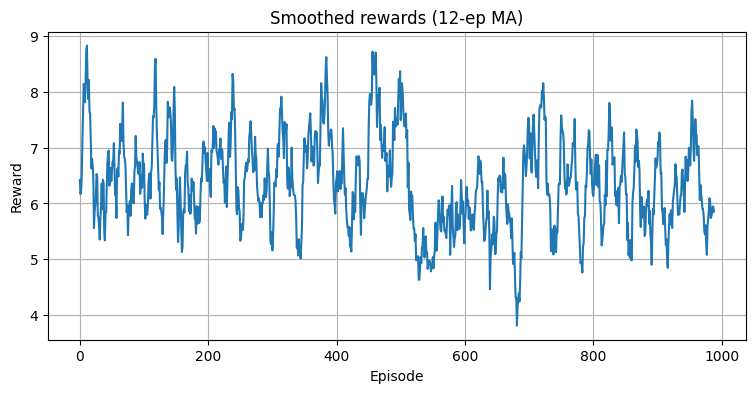

In [ ]:
# import Libraries
import math, random, time, os, json
from collections import deque, namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import textwrap


# Helper: pprint Instagram-style post
def print_instagram_post(post, explain, reward):
    # human-friendly (feed) block
    print("-" * 60)
    print(f"POST ID: {post['post_id']}  | Creator: @{post['creator']}")
    print(f"Image: {post['image_url']}")
    print(f"Title: {post['title']}")
    print(f"Topic: {post['topic']}  | Language: {post['language']}  | Popularity: {post['popularity']:.2f}")
    # caption (truncate)
    caption = post['caption']
    if len(caption) > 140:
        caption = caption[:137] + "..."
    print("Caption:", caption)
    # technical explainability under a folded section
    print("\n[Why recommended — technical explanation]")
    for k, v in explain.items():
        print(f"  {k}: {v}")
    print(f"Final Reward (this action): {reward:.3f}")
    print("-" * 60 + "\n")

# Post Generator

def make_post_catalog(n_posts=600, content_dim=24, n_topics=12, n_langs=4, seed=42):
    random.seed(seed); np.random.seed(seed)
    posts = []
    topic_names = [f"Topic_{i}" for i in range(n_topics)]
    lang_names = ["English", "Hindi", "Spanish", "Kannada"][:n_langs]
    n_creators = max(40, n_posts//8)
    base_embeddings = np.random.normal(scale=0.6, size=(n_posts, content_dim)).astype(np.float32)
    topic_vectors = np.random.normal(scale=0.5, size=(n_topics, content_dim)).astype(np.float32)
    for pid in range(n_posts):
        topic = random.randint(0, n_topics-1)
        lang = random.randint(0, n_langs-1)
        creator = f"creator{random.randint(1, n_creators)}"
        # synthetic caption and title
        title = f"{topic_names[topic]} — {random.choice(['Explained','Tips','Best Practices','Fun Fact','How-to'])}"
        caption = f"A short post about {topic_names[topic]} with insights and examples. #learn #{topic_names[topic]}"
        image_url = f"https://placehold.it/640x640?text=post{pid}"
        emb = base_embeddings[pid] + topic_vectors[topic] + np.random.normal(scale=0.02, size=(content_dim,))
        emb = emb / (np.linalg.norm(emb) + 1e-9)
        popularity = float(np.clip(np.random.beta(2,8) * 1.5 + 0.05, 0.01, 2.0))
        posts.append({
            "post_id": pid,
            "embedding": emb.astype(np.float32),
            "topic_id": topic,
            "topic": topic_names[topic],
            "language_id": lang,
            "language": lang_names[lang],
            "creator": creator,
            "title": title,
            "caption": caption,
            "image_url": image_url,
            "popularity": popularity
        })
    return posts, topic_names, lang_names

# Enhanced Environment with posts + users + social graph + explainability
class SocialInstagramEnv:
    def __init__(self, posts, content_dim=24, n_users=600, K=6, seed=1, frac_new_users=0.18):
        random.seed(seed); np.random.seed(seed)
        self.posts = posts
        self.n_posts = len(posts)
        self.content_dim = content_dim
        self.K = K
        self.n_users = n_users
        # user base embeddings: cluster by topics for realistic preferences
        self.users = np.random.normal(scale=0.5, size=(n_users, content_dim)).astype(np.float32)
        # create topic bias for users
        n_topics = max(1, max(p['topic_id'] for p in posts) + 1)
        topic_vectors = np.zeros((n_topics, content_dim), dtype=np.float32)
        for p in posts:
            topic_vectors[p['topic_id']] += p['embedding']
        # normalize topic vectors
        for i in range(n_topics):
            if np.linalg.norm(topic_vectors[i]) > 0:
                topic_vectors[i] /= np.linalg.norm(topic_vectors[i])
        user_topic_assign = np.random.randint(0, n_topics, size=n_users)
        for u in range(n_users):
            self.users[u] += 0.8 * topic_vectors[user_topic_assign[u]]
        # normalize
        self.users /= np.clip(np.linalg.norm(self.users, axis=1, keepdims=True), 1e-9, None)

        # language prefs (soft)
        self.n_langs = max(p['language_id'] for p in posts) + 1
        self.user_lang_pref = np.zeros((n_users, self.n_langs), dtype=np.float32)
        for u in range(n_users):
            p = np.random.dirichlet([1.0]*self.n_langs)
            self.user_lang_pref[u] = p

        # social graph (friends)
        self.friends = [set() for _ in range(n_users)]
        for u in range(n_users):
            for _ in range(3):
                v = (u + random.randint(1,30)) % n_users
                self.friends[u].add(v); self.friends[v].add(u)
            if random.random() < 0.06:
                v = random.randint(0, n_users-1)
                self.friends[u].add(v); self.friends[v].add(u)

        self.user_hist = [deque(maxlen=80) for _ in range(n_users)]
        self.user_interactions = np.zeros(n_users, dtype=np.int32)

        # cold-start flags
        new_count = int(frac_new_users * n_users)
        self.is_new_user = np.zeros(n_users, dtype=bool)
        new_users_idx = np.random.choice(n_users, size=new_count, replace=False)
        self.is_new_user[new_users_idx] = True

        # runtime state
        self.current_user = None
        self.current_candidates = None
        self.step_in_session = 0
        self.max_session_len = 8
        self.temperature = 1.0
        self.last_session_used_friend_init = False

    def reset(self, user_id=None, user_profile_input=None):
        """
        user_profile_input: optional dict with 'language' (string), 'topics' (list of topic indices)
        if provided, we will adjust the user's embedding accordingly (simulate entering preferences on signup).
        Otherwise, if user is new, we use friend-based init or population default.
        """
        if user_id is None:
            self.current_user = np.random.randint(0, self.n_users)
        else:
            self.current_user = int(user_id)
        u = self.current_user
        self.step_in_session = 0
        self.current_candidates = np.random.choice(self.n_posts, size=self.K, replace=False)
        self.last_session_used_friend_init = False

        # if user provided profile input (e.g., at signup), incorporate
        if user_profile_input:
            # language: if given, set a strong language preference
            if 'language' in user_profile_input:
                lang_idx = user_profile_input['language']
                # set soft one-hot with slight smoothness
                pref = np.ones(self.n_langs) * 0.02
                pref[lang_idx] = 0.9
                self.user_lang_pref[u] = pref / np.sum(pref)
            # topics: adjust user embedding toward average of those topic embeddings
            if 'topics' in user_profile_input and len(user_profile_input['topics']) > 0:
                # compute average embedding of posts in these topics
                topic_embs = []
                for p in self.posts:
                    if p['topic_id'] in user_profile_input['topics']:
                        topic_embs.append(p['embedding'])
                if topic_embs:
                    avg = np.mean(np.stack(topic_embs, axis=0), axis=0)
                    alpha = 0.9  # strong onboarding preference
                    self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*avg)
                # mark user as not-new anymore
                self.is_new_user[u] = False

        # friend-based cold-start if new and few interactions
        if (self.is_new_user[u] or self.user_interactions[u] < 2) and not user_profile_input:
            friends = list(self.friends[u])
            friend_embs = []
            for f in friends:
                if self.user_interactions[f] > 0:
                    friend_embs.append(self.users[f])
            if friend_embs:
                avg = np.mean(np.stack(friend_embs, axis=0), axis=0)
                alpha = 0.6
                self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*avg)
                self.last_session_used_friend_init = True

        return self._get_state()

    def _norm(self, v):
        n = np.linalg.norm(v)
        return v / (n + 1e-9)

    def _get_state(self):
        u = self.current_user
        u_emb = self.users[u]
        lang_pref = self.user_lang_pref[u]
        cand_embs = np.concatenate([self.posts[c]['embedding'] for c in self.current_candidates])
        pop = np.array([self.posts[c]['popularity'] for c in self.current_candidates], dtype=np.float32)
        hist = np.array([self.user_hist[self.current_user].count(int(cid)) for cid in self.current_candidates], dtype=np.float32)
        prog = np.array([self.step_in_session / max(1, self.max_session_len)], dtype=np.float32)
        state = np.concatenate([u_emb, lang_pref, cand_embs, pop, hist, prog]).astype(np.float32)
        return state

    def step(self, action, update_user_online=True):
        assert 0 <= action < self.K
        cid = int(self.current_candidates[action])
        post = self.posts[cid]
        u = self.current_user

        user_emb = self.users[u]
        content_emb = post['embedding']
        score = float(np.dot(user_emb, content_emb)) * (post['popularity']) / self.temperature

        # language match bonus
        user_top_lang = int(np.argmax(self.user_lang_pref[u]))
        content_lang = post['language_id']
        lang_bonus = 0.25 if user_top_lang == content_lang else 0.0

        p_raw = 1/(1+math.exp(-score))
        p_click = np.clip(p_raw * (1 + lang_bonus), 0.0, 0.999)

        clicked = np.random.rand() < p_click
        watch_prop = 0.0
        if clicked:
            watch_prop = np.clip(np.random.beta(2+max(0, score), 2), 0, 1)

        r_engage = 0.0
        if clicked:
            r_engage += 1.0
            if watch_prop > 0.5: r_engage += 1.0
            if watch_prop > 0.9: r_engage += 1.0
            r_engage += 0.12 * np.log1p(post['popularity'])

        rep_pen = -0.6 if cid in self.user_hist[u] else 0.0
        diversity_bonus = 0.25 if post['popularity'] < 0.2 else 0.0
        retention = 0.0
        if clicked and watch_prop > 0.65 and self.step_in_session >= 1:
            retention = 0.6

        reward = float(r_engage + retention + diversity_bonus + rep_pen)

        # explainability computations
        sim = float(np.dot(user_emb, content_emb))
        # friend-match: estimate how many friends interacted with similar topic
        friends = list(self.friends[u])
        friend_match = 0.0
        if friends:
            cnt = 0
            for f in friends:
                # friend preference similarity to this post
                cnt += float(np.dot(self.users[f], content_emb) > 0.4)
            friend_match = cnt / max(1, len(friends))

        # update history & counts
        self.user_hist[u].append(cid)
        self.user_interactions[u] += 1

        # online user embedding update (EMA) to simulate learning
        if clicked and update_user_online:
            alpha = 0.12
            self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*content_emb)

        # popularity drift
        if clicked:
            post['popularity'] = float(np.clip(post['popularity'] + 0.02, 0.01, 2.0))

        # session advance
        self.step_in_session += 1
        done = (self.step_in_session >= self.max_session_len)
        if not done:
            replace_idx = np.random.randint(0, self.K)
            pool = list(set(range(self.n_posts)) - set(self.current_candidates))
            # sometimes inject trending or similar topic posts
            if random.random() < 0.14:
                # pick a high-pop item
                top_idx = np.argsort([p['popularity'] for p in self.posts])[-80:]
                new_c = int(np.random.choice(top_idx))
            else:
                new_c = int(np.random.choice(pool))
            self.current_candidates[replace_idx] = new_c

        explain = {
            "similarity": sim,
            "language_match": bool(user_top_lang == content_lang),
            "friend_match_fraction": round(friend_match, 3),
            "popularity": round(post['popularity'], 3),
            "repetition_penalty_applied": bool(rep_pen < 0)
        }

        next_state = self._get_state() if not done else None
        info = {"clicked": clicked, "watch_prop": watch_prop, "post": post, "explain": explain, "used_friend_init": self.last_session_used_friend_init}
        return next_state, reward, done, info

    def action_space_n(self): return self.K
    def state_size(self): return self.content_dim + self.n_langs + self.K*self.content_dim + self.K + self.K + 1


# A2C 

class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden=256):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(hidden, action_dim)   # logits
        self.value_head = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.base(x)
        logits = self.policy_head(h)
        value = self.value_head(h).squeeze(-1)
        return logits, value

class A2CAgent:
    def __init__(self, state_dim, action_dim, device='cpu', lr=3e-4, gamma=0.99,
                 value_coef=0.5, entropy_coef=0.01, max_grad_norm=0.5):
        self.device = device
        self.net = ActorCritic(state_dim, action_dim).to(self.device)
        self.opt = optim.Adam(self.net.parameters(), lr=lr)
        self.gamma = gamma
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.action_dim = action_dim

    def select_action(self, state, prefer_explore=False):
        # state: numpy array
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        logits, value = self.net(s)
        probs = torch.softmax(logits, dim=-1)
        # optional exploration: flatten distribution a bit
        if prefer_explore:
            # mix with uniform to encourage exploration
            probs = probs * 0.7 + (0.3 / self.action_dim)
            probs = probs / probs.sum(dim=-1, keepdim=True)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        logp = m.log_prob(action)
        entropy = m.entropy()
        return int(action.item()), float(logp.item()), float(entropy.item()), float(value.item())

    def update(self, traj):
        """
        traj: dict with lists: states, actions, rewards, dones, logps, values, entropies
        We'll compute discounted returns and advantages (returns - values),
        then update policy and value networks.
        """
        states = torch.tensor(np.stack(traj['states']), dtype=torch.float32, device=self.device)
        actions = torch.tensor(traj['actions'], dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = traj['rewards']
        dones = traj['dones']
        logps = torch.tensor(traj['logps'], dtype=torch.float32, device=self.device).unsqueeze(1)
        values = torch.tensor(traj['values'], dtype=torch.float32, device=self.device).unsqueeze(1)
        entropies = torch.tensor(traj['entropies'], dtype=torch.float32, device=self.device).unsqueeze(1)

        # compute discounted returns (per-step)
        returns = []
        R = 0.0
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d:
                R = 0.0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32, device=self.device).unsqueeze(1)

        # advantages
        advantages = returns - values

        # normalize advantages for stability
        adv_mean = advantages.mean()
        adv_std = advantages.std(unbiased=False) + 1e-8
        advantages = (advantages - adv_mean) / adv_std

        # Recompute policy logits for states to get current logprobs (stable training)
        logits, value_preds = self.net(states)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        current_logps = dist.log_prob(actions.squeeze(1)).unsqueeze(1)
        entropy = dist.entropy().unsqueeze(1)

        actor_loss = - (current_logps * advantages).mean()
        critic_loss = nn.functional.mse_loss(value_preds.unsqueeze(1), returns)
        entropy_loss = - entropy.mean()

        loss = actor_loss + self.value_coef * critic_loss + self.entropy_coef * entropy_loss

        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
        self.opt.step()

        return {
            "total_loss": float(loss.item()),
            "actor_loss": float(actor_loss.item()),
            "critic_loss": float(critic_loss.item()),
            "entropy": float(entropy.mean().item())
        }


# Training / evaluate / demo flow

def train_agent(env, agent, episodes=1000, max_steps_per_episode=40):
    rewards_all, losses_all = [], []
    for ep in range(episodes):
        state = env.reset()
        prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
        traj = {"states": [], "actions": [], "rewards": [], "dones": [], "logps": [], "values": [], "entropies": []}
        ep_rew = 0.0; done = False; steps = 0
        while not done and steps < max_steps_per_episode:
            a, logp, entropy, value = agent.select_action(state, prefer_explore=prefer_explore)
            next_s, r, done, info = env.step(a, update_user_online=True)
            traj['states'].append(state)
            traj['actions'].append(a)
            traj['rewards'].append(r)
            traj['dones'].append(done)
            traj['logps'].append(logp)
            traj['values'].append(value)
            traj['entropies'].append(entropy)
            state = next_s if next_s is not None else state
            ep_rew += r
            steps += 1

        # After episode, update actor-critic with the collected trajectory
        loss_info = agent.update(traj)
        losses_all.append(loss_info['total_loss'])
        rewards_all.append(ep_rew)

        if (ep+1) % 30 == 0:
            print(f"Episode {ep+1}/{episodes} avg last30 reward: {np.mean(rewards_all[-30:]):.3f} avg loss: {np.mean(losses_all[-30:]):.4f}")
    return rewards_all, losses_all

def evaluate(env, agent, episodes=220):
    total=0.0; clicks=0; sessions=0; friend_init_sessions=0
    for _ in range(episodes):
        state = env.reset()
        if env.last_session_used_friend_init: friend_init_sessions += 1
        prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
        done=False; sess_rew=0.0
        while not done:
            a, _, _, _ = agent.select_action(state, prefer_explore=prefer_explore)
            next_s, r, done, info = env.step(a, update_user_online=True)
            state = next_s if next_s is not None else state
            sess_rew += r
            if info.get("clicked", False): clicks += 1
        total += sess_rew; sessions += 1
    return {"avg_reward": total/sessions, "clicks_per_session": clicks/sessions, "friend_init_sessions": friend_init_sessions}

# User-facing demo
def demo_user_flow(env, agent):
    print("\n--- DEMO: Create account or press Enter to skip (cold-start) ---")
    name = input("Enter a username (or press Enter to simulate anonymous new user): ").strip()
    user_provided_prefs = None
    if name:
        print("Optionally provide initial preferences to help cold-start.")
        lang_choice = input(f"Choose language (0..{env.n_langs-1}) or press Enter to skip: ").strip()
        topics_choice = input("Enter comma-separated topic indices (e.g., 0,2) or press Enter to skip: ").strip()
        prefs = {}
        if lang_choice != "":
            try:
                li = int(lang_choice)
                prefs['language'] = li
            except:
                print("Invalid language choice — skipping.")
        if topics_choice != "":
            try:
                topics = [int(x.strip()) for x in topics_choice.split(",") if x.strip()!='']
                prefs['topics'] = topics
            except:
                print("Invalid topics — skipping.")
        if prefs:
            user_provided_prefs = prefs
        # create a new user id (we will simply pick a random user slot and treat it as 'you')
        user_slot = random.randint(0, env.n_users-1)
        print(f"Created account @{name} (internal user id = {user_slot}). Using provided prefs: {user_provided_prefs}")
        state = env.reset(user_id=user_slot, user_profile_input=user_provided_prefs)
        uid = user_slot
    else:
        print("No username provided — simulating fully automatic cold-start.")
        uid = None
        state = env.reset()

    # show a short feed (session)
    print("\n--- Showing a short Instagram-style feed (session) ---\n")
    steps = 6
    for step in range(steps):
        prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
        a, _, _, _ = agent.select_action(state, prefer_explore=prefer_explore)
        next_state, reward, done, info = env.step(a, update_user_online=True)
        post = info['post']
        explain = info['explain']
        # human + technical output
        print_instagram_post(post, explain, reward)
        # after printing, prompt simulated user action (like / skip / view long)
        action = input("Your action? [l = like, s = skip, v = view long, q = quit session] (default skip): ").strip().lower()
        # interpret user action to simulate stronger interaction
        if action == 'l':
            # force-click: we simulate strong engagement by re-running update_user_online effect
            # directly update the user's embedding toward the post (stronger)
            u = env.current_user
            env.users[u] = env._norm((1-0.25)*env.users[u] + 0.25*post['embedding'])
            print("You liked the post — user profile updated.")
        elif action == 'v':
            # simulate long watch: increase popularity and give additional reward print
            post['popularity'] = float(np.clip(post['popularity'] + 0.04, 0.01, 3.0))
            print("You viewed the post in detail (long watch).")
        elif action == 'q':
            print("Ending session early.")
            break
        # show delta in user preference approx by reporting the top-3 nearest topics before/after (approx)
        uid_cur = env.current_user
        # compute distances to topic centroids
        topic_scores = {}
        for p in env.posts:
            t = p['topic']
            if t not in topic_scores: topic_scores[t] = 0.0
            topic_scores[t] += float(np.dot(env.users[uid_cur], p['embedding'])) * p['popularity']
        # sort
        sorted_topics = sorted(topic_scores.items(), key=lambda x:-x[1])[:5]
        print("Top inferred topics for you now (approx):")
        for t, sc in sorted_topics:
            print(f"  {t} (score {sc:.2f})")
        if done:
            print("Session finished.\n")
            break
        state = next_state if next_state is not None else state

# Main
if __name__ == "__main__":
    print("Initializing post catalog...")
    posts, topic_names, lang_names = make_post_catalog(n_posts=800, content_dim=24, n_topics=12, n_langs=4, seed=101)
    print(f"Catalog contains {len(posts)} posts across {len(topic_names)} topics and languages: {lang_names}")

    env = SocialInstagramEnv(posts=posts, content_dim=24, n_users=800, K=6, seed=2025, frac_new_users=0.2)
    state_dim = env.state_size(); action_dim = env.action_space_n()
    agent = A2CAgent(state_dim, action_dim, device='cpu', lr=3.5e-4, gamma=0.98, value_coef=0.5, entropy_coef=0.01)

    print("\nTraining agent (A2C) — increase episodes for a stronger policy...")
    t0 = time.time()
    rewards, losses = train_agent(env, agent, episodes=1000)
    print("Training time:", time.time() - t0)

    print("\nEvaluating agent...")
    metrics = evaluate(env, agent, episodes=800)
    print("Evaluation metrics:", metrics)

    # show demo interactive user flow
    demo_user_flow(env, agent)

    # save
    os.makedirs("models", exist_ok=True)
    torch.save(agent.net.state_dict(), "models/a2c_socialrec_instagram.pth")
    pd.DataFrame({"episode": np.arange(1,len(rewards)+1), "reward": rewards}).to_csv("training_rewards_instagram_a2c.csv", index=False)
    print("Model saved to models/a2c_socialrec_instagram.pth; training rewards saved to training_rewards_instagram_a2c.csv")
    # plot smoothed rewards
    plt.figure(figsize=(9,4))
    if len(rewards) >= 12:
        plt.plot(np.convolve(rewards, np.ones(12)/12, mode='valid'))
        plt.title("Smoothed rewards (12-ep MA)")
    else:
        plt.plot(rewards)
        plt.title("Rewards")
    plt.xlabel("Episode"); plt.ylabel("Reward"); plt.grid(True); plt.show()


# **Social Media Recommendation Agent Using Actor–Critic (A2C)**

Initializing post catalog...
Catalog contains 800 posts across 12 topics and languages: ['English', 'Hindi', 'Spanish', 'Other']

Training agent (PPO) — increase epochs/timesteps for a stronger policy...
Epoch 1/1000  reward_sum_rollout: 3404.284  actor_loss: 0.1063 critic_loss: 2.5400 time: 6.7s
Epoch 5/1000  reward_sum_rollout: 3332.316  actor_loss: -0.1162 critic_loss: 3.1586 time: 5.6s
Epoch 10/1000  reward_sum_rollout: 3496.191  actor_loss: 0.0639 critic_loss: 2.4003 time: 5.7s
Epoch 15/1000  reward_sum_rollout: 3772.172  actor_loss: 0.2070 critic_loss: 3.2717 time: 5.1s
Epoch 20/1000  reward_sum_rollout: 3897.542  actor_loss: -0.0046 critic_loss: 2.4210 time: 5.2s
Epoch 25/1000  reward_sum_rollout: 4038.630  actor_loss: 0.0751 critic_loss: 3.3332 time: 5.8s
Epoch 30/1000  reward_sum_rollout: 4288.650  actor_loss: -0.0624 critic_loss: 2.8076 time: 5.8s
Epoch 35/1000  reward_sum_rollout: 4395.376  actor_loss: -0.1695 critic_loss: 2.7949 time: 5.3s
Epoch 40/1000  reward_sum_rollout:

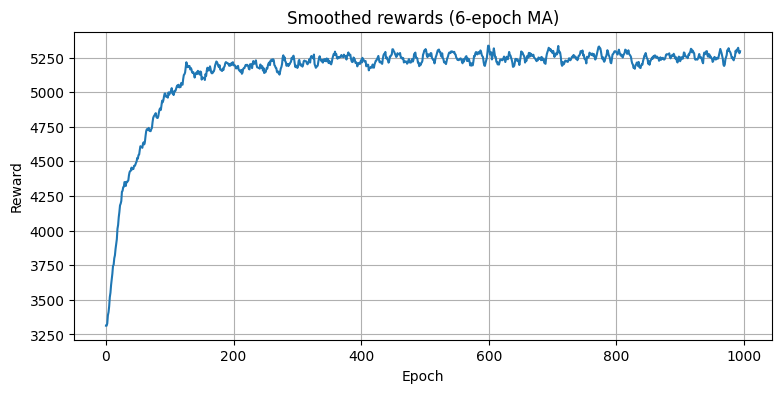

In [ ]:
# import Libraries
import math, random, time, os, json
from collections import deque, namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import textwrap

# Helper:  print Instagram-style post
def print_instagram_post(post, explain, reward):
    # human-friendly (feed) block
    print("-" * 60)
    print(f"POST ID: {post['post_id']}  | Creator: @{post['creator']}")
    print(f"Image: {post['image_url']}")
    print(f"Title: {post['title']}")
    print(f"Topic: {post['topic']}  | Language: {post['language']}  | Popularity: {post['popularity']:.2f}")
    # caption (truncate)
    caption = post['caption']
    if len(caption) > 140:
        caption = caption[:137] + "..."
    print("Caption:", caption)
    # technical explainability under a folded section
    print("\n[Why recommended — technical explanation]")
    for k, v in explain.items():
        print(f"  {k}: {v}")
    print(f"Final Reward (this action): {reward:.3f}")
    print("-" * 60 + "\n")

# Post  Generator
def make_post_catalog(n_posts=600, content_dim=24, n_topics=12, n_langs=4, seed=42):
    random.seed(seed); np.random.seed(seed)
    posts = []
    topic_names = [f"Topic_{i}" for i in range(n_topics)]
    lang_names = ["English", "Hindi", "Spanish", "Other"][:n_langs]
    n_creators = max(40, n_posts//8)
    base_embeddings = np.random.normal(scale=0.6, size=(n_posts, content_dim)).astype(np.float32)
    topic_vectors = np.random.normal(scale=0.5, size=(n_topics, content_dim)).astype(np.float32)
    for pid in range(n_posts):
        topic = random.randint(0, n_topics-1)
        lang = random.randint(0, n_langs-1)
        creator = f"creator{random.randint(1, n_creators)}"
        # synthetic caption and title
        title = f"{topic_names[topic]} — {random.choice(['Explained','Tips','Best Practices','Fun Fact','How-to'])}"
        caption = f"A short post about {topic_names[topic]} with insights and examples. #learn #{topic_names[topic]}"
        image_url = f"https://placehold.it/640x640?text=post{pid}"
        emb = base_embeddings[pid] + topic_vectors[topic] + np.random.normal(scale=0.02, size=(content_dim,))
        emb = emb / (np.linalg.norm(emb) + 1e-9)
        popularity = float(np.clip(np.random.beta(2,8) * 1.5 + 0.05, 0.01, 2.0))
        posts.append({
            "post_id": pid,
            "embedding": emb.astype(np.float32),
            "topic_id": topic,
            "topic": topic_names[topic],
            "language_id": lang,
            "language": lang_names[lang],
            "creator": creator,
            "title": title,
            "caption": caption,
            "image_url": image_url,
            "popularity": popularity
        })
    return posts, topic_names, lang_names

# Enhanced Environment with posts + users + social graph + explainability
class SocialInstagramEnv:
    def __init__(self, posts, content_dim=24, n_users=600, K=6, seed=1, frac_new_users=0.18):
        random.seed(seed); np.random.seed(seed)
        self.posts = posts
        self.n_posts = len(posts)
        self.content_dim = content_dim
        self.K = K
        self.n_users = n_users
        # user base embeddings: cluster by topics for realistic preferences
        self.users = np.random.normal(scale=0.5, size=(n_users, content_dim)).astype(np.float32)
        # create topic bias for users
        n_topics = max(1, max(p['topic_id'] for p in posts) + 1)
        topic_vectors = np.zeros((n_topics, content_dim), dtype=np.float32)
        for p in posts:
            topic_vectors[p['topic_id']] += p['embedding']
        # normalize topic vectors
        for i in range(n_topics):
            if np.linalg.norm(topic_vectors[i]) > 0:
                topic_vectors[i] /= np.linalg.norm(topic_vectors[i])
        user_topic_assign = np.random.randint(0, n_topics, size=n_users)
        for u in range(n_users):
            self.users[u] += 0.8 * topic_vectors[user_topic_assign[u]]
        # normalize
        self.users /= np.clip(np.linalg.norm(self.users, axis=1, keepdims=True), 1e-9, None)

        # language prefs (soft)
        self.n_langs = max(p['language_id'] for p in posts) + 1
        self.user_lang_pref = np.zeros((n_users, self.n_langs), dtype=np.float32)
        for u in range(n_users):
            p = np.random.dirichlet([1.0]*self.n_langs)
            self.user_lang_pref[u] = p

        # social graph (friends)
        self.friends = [set() for _ in range(n_users)]
        for u in range(n_users):
            for _ in range(3):
                v = (u + random.randint(1,30)) % n_users
                self.friends[u].add(v); self.friends[v].add(u)
            if random.random() < 0.06:
                v = random.randint(0, n_users-1)
                self.friends[u].add(v); self.friends[v].add(u)

        self.user_hist = [deque(maxlen=80) for _ in range(n_users)]
        self.user_interactions = np.zeros(n_users, dtype=np.int32)

        # cold-start flags
        new_count = int(frac_new_users * n_users)
        self.is_new_user = np.zeros(n_users, dtype=bool)
        new_users_idx = np.random.choice(n_users, size=new_count, replace=False)
        self.is_new_user[new_users_idx] = True

        # runtime state
        self.current_user = None
        self.current_candidates = None
        self.step_in_session = 0
        self.max_session_len = 8
        self.temperature = 1.0
        self.last_session_used_friend_init = False

    def reset(self, user_id=None, user_profile_input=None):
        """
        user_profile_input: optional dict with 'language' (string), 'topics' (list of topic indices)
        if provided, we will adjust the user's embedding accordingly (simulate entering preferences on signup).
        Otherwise, if user is new, we use friend-based init or population default.
        """
        if user_id is None:
            self.current_user = np.random.randint(0, self.n_users)
        else:
            self.current_user = int(user_id)
        u = self.current_user
        self.step_in_session = 0
        self.current_candidates = np.random.choice(self.n_posts, size=self.K, replace=False)
        self.last_session_used_friend_init = False

        # if user provided profile input (e.g., at signup), incorporate
        if user_profile_input:
            # language: if given, set a strong language preference
            if 'language' in user_profile_input:
                lang_idx = user_profile_input['language']
                # set soft one-hot with slight smoothness
                pref = np.ones(self.n_langs) * 0.02
                pref[lang_idx] = 0.9
                self.user_lang_pref[u] = pref / np.sum(pref)
            # topics: adjust user embedding toward average of those topic embeddings
            if 'topics' in user_profile_input and len(user_profile_input['topics']) > 0:
                # compute average embedding of posts in these topics
                topic_embs = []
                for p in self.posts:
                    if p['topic_id'] in user_profile_input['topics']:
                        topic_embs.append(p['embedding'])
                if topic_embs:
                    avg = np.mean(np.stack(topic_embs, axis=0), axis=0)
                    alpha = 0.9  # strong onboarding preference
                    self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*avg)
                # mark user as not-new anymore
                self.is_new_user[u] = False

        # friend-based cold-start if new and few interactions
        if (self.is_new_user[u] or self.user_interactions[u] < 2) and not user_profile_input:
            friends = list(self.friends[u])
            friend_embs = []
            for f in friends:
                if self.user_interactions[f] > 0:
                    friend_embs.append(self.users[f])
            if friend_embs:
                avg = np.mean(np.stack(friend_embs, axis=0), axis=0)
                alpha = 0.6
                self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*avg)
                self.last_session_used_friend_init = True

        return self._get_state()

    def _norm(self, v):
        n = np.linalg.norm(v)
        return v / (n + 1e-9)

    def _get_state(self):
        u = self.current_user
        u_emb = self.users[u]
        lang_pref = self.user_lang_pref[u]
        cand_embs = np.concatenate([self.posts[c]['embedding'] for c in self.current_candidates])
        pop = np.array([self.posts[c]['popularity'] for c in self.current_candidates], dtype=np.float32)
        hist = np.array([self.user_hist[self.current_user].count(int(cid)) for cid in self.current_candidates], dtype=np.float32)
        prog = np.array([self.step_in_session / max(1, self.max_session_len)], dtype=np.float32)
        state = np.concatenate([u_emb, lang_pref, cand_embs, pop, hist, prog]).astype(np.float32)
        return state

    def step(self, action, update_user_online=True):
        assert 0 <= action < self.K
        cid = int(self.current_candidates[action])
        post = self.posts[cid]
        u = self.current_user

        user_emb = self.users[u]
        content_emb = post['embedding']
        score = float(np.dot(user_emb, content_emb)) * (post['popularity']) / self.temperature

        # language match bonus
        user_top_lang = int(np.argmax(self.user_lang_pref[u]))
        content_lang = post['language_id']
        lang_bonus = 0.25 if user_top_lang == content_lang else 0.0

        p_raw = 1/(1+math.exp(-score))
        p_click = np.clip(p_raw * (1 + lang_bonus), 0.0, 0.999)

        clicked = np.random.rand() < p_click
        watch_prop = 0.0
        if clicked:
            watch_prop = np.clip(np.random.beta(2+max(0, score), 2), 0, 1)

        r_engage = 0.0
        if clicked:
            r_engage += 1.0
            if watch_prop > 0.5: r_engage += 1.0
            if watch_prop > 0.9: r_engage += 1.0
            r_engage += 0.12 * np.log1p(post['popularity'])

        rep_pen = -0.6 if cid in self.user_hist[u] else 0.0
        diversity_bonus = 0.25 if post['popularity'] < 0.2 else 0.0
        retention = 0.0
        if clicked and watch_prop > 0.65 and self.step_in_session >= 1:
            retention = 0.6

        reward = float(r_engage + retention + diversity_bonus + rep_pen)

        # explainability computations
        sim = float(np.dot(user_emb, content_emb))
        # friend-match: estimate how many friends interacted with similar topic
        friends = list(self.friends[u])
        friend_match = 0.0
        if friends:
            cnt = 0
            for f in friends:
                # friend preference similarity to this post
                cnt += float(np.dot(self.users[f], content_emb) > 0.4)
            friend_match = cnt / max(1, len(friends))

        # update history & counts
        self.user_hist[u].append(cid)
        self.user_interactions[u] += 1

        # online user embedding update (EMA) to simulate learning
        if clicked and update_user_online:
            alpha = 0.12
            self.users[u] = self._norm((1-alpha)*self.users[u] + alpha*content_emb)

        # popularity drift
        if clicked:
            post['popularity'] = float(np.clip(post['popularity'] + 0.02, 0.01, 2.0))

        # session advance
        self.step_in_session += 1
        done = (self.step_in_session >= self.max_session_len)
        if not done:
            replace_idx = np.random.randint(0, self.K)
            pool = list(set(range(self.n_posts)) - set(self.current_candidates))
            # sometimes inject trending or similar topic posts
            if random.random() < 0.14:
                # pick a high-pop item
                top_idx = np.argsort([p['popularity'] for p in self.posts])[-80:]
                new_c = int(np.random.choice(top_idx))
            else:
                new_c = int(np.random.choice(pool))
            self.current_candidates[replace_idx] = new_c

        explain = {
            "similarity": sim,
            "language_match": bool(user_top_lang == content_lang),
            "friend_match_fraction": round(friend_match, 3),
            "popularity": round(post['popularity'], 3),
            "repetition_penalty_applied": bool(rep_pen < 0)
        }

        next_state = self._get_state() if not done else None
        info = {"clicked": clicked, "watch_prop": watch_prop, "post": post, "explain": explain, "used_friend_init": self.last_session_used_friend_init}
        return next_state, reward, done, info

    def action_space_n(self): return self.K
    def state_size(self): return self.content_dim + self.n_langs + self.K*self.content_dim + self.K + self.K + 1

# PPO components

class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden=256):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(hidden, action_dim)   # logits
        self.value_head = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.base(x)
        logits = self.policy_head(h)
        value = self.value_head(h).squeeze(-1)
        return logits, value

class PPOAgent:
    def __init__(self, state_dim, action_dim, device='cpu',
                 lr=3e-4, gamma=0.99, lam=0.95,
                 clip_eps=0.2, epochs=4, minibatch_size=64,
                 value_coef=0.5, entropy_coef=0.01, max_grad_norm=0.5):
        self.device = device
        self.net = ActorCritic(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.action_dim = action_dim

    def get_action_and_value(self, state):
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        logits, value = self.net(s)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        logp = dist.log_prob(action)
        entropy = dist.entropy()
        return int(action.item()), float(logp.item()), float(entropy.item()), float(value.item())

    def compute_gae(self, rewards, values, dones, last_value):
        """
        rewards: list
        values: list
        dones: list (bool)
        last_value: float (value estimate for last next_state, 0 if terminal)
        returns: advantages list and returns list (target)
        """
        advantages = []
        gae = 0.0
        values_ext = values + [last_value]
        for step in reversed(range(len(rewards))):
            mask = 0.0 if dones[step] else 1.0
            delta = rewards[step] + self.gamma * values_ext[step+1] * mask - values_ext[step]
            gae = delta + self.gamma * self.lam * mask * gae
            advantages.insert(0, gae)
        returns = [adv + val for adv, val in zip(advantages, values)]
        return advantages, returns

    def update(self, rollout):
        """
        rollout: dict of lists: states, actions, logps, returns, advantages, values
        Performs multiple epochs of minibatch updates
        """
        states = torch.tensor(np.stack(rollout['states']), dtype=torch.float32, device=self.device)
        actions = torch.tensor(rollout['actions'], dtype=torch.long, device=self.device)
        old_logps = torch.tensor(rollout['logps'], dtype=torch.float32, device=self.device)
        returns = torch.tensor(rollout['returns'], dtype=torch.float32, device=self.device)
        advantages = torch.tensor(rollout['advantages'], dtype=torch.float32, device=self.device)
        # normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std(unbiased=False) + 1e-8)

        N = states.size(0)
        inds = np.arange(N)
        for epoch in range(self.epochs):
            np.random.shuffle(inds)
            for start in range(0, N, self.minibatch_size):
                mb_inds = inds[start:start+self.minibatch_size]
                mb_states = states[mb_inds]
                mb_actions = actions[mb_inds]
                mb_old_logps = old_logps[mb_inds]
                mb_returns = returns[mb_inds]
                mb_adv = advantages[mb_inds]

                logits, value_preds = self.net(mb_states)
                probs = torch.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                mb_logps = dist.log_prob(mb_actions)
                mb_entropy = dist.entropy().mean()

                ratio = torch.exp(mb_logps - mb_old_logps)
                surr1 = ratio * mb_adv
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * mb_adv
                actor_loss = - torch.min(surr1, surr2).mean()
                critic_loss = nn.functional.mse_loss(value_preds, mb_returns)
                loss = actor_loss + self.value_coef * critic_loss - self.entropy_coef * mb_entropy

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.optimizer.step()

        return {
            "actor_loss": float(actor_loss.item()),
            "critic_loss": float(critic_loss.item()),
            "entropy": float(mb_entropy.item())
        }

# Training / evaluate / demo flow

def collect_rollout(env, agent, timesteps_per_rollout=2048, max_steps_per_episode=40):
    """
    Collects interactions until timesteps_per_rollout reached.
    Returns a rollout dict suitable for PPO update.
    """
    states, actions, rewards, dones, logps, values = [], [], [], [], [], []
    steps_collected = 0
    while steps_collected < timesteps_per_rollout:
        state = env.reset()
        done = False
        step = 0
        while not done and steps_collected < timesteps_per_rollout and step < max_steps_per_episode:
            prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
            a, logp, entropy, value = agent.get_action_and_value(state)
            next_s, r, done, info = env.step(a, update_user_online=True)
            states.append(state)
            actions.append(a)
            rewards.append(r)
            dones.append(done)
            logps.append(logp)
            values.append(value)
            steps_collected += 1
            state = next_s if next_s is not None else state
            step += 1
    # compute last_value for GAE: use value of the last state (non-terminal)
    # take last state's value (if last done True, last_value=0)
    if dones[-1]:
        last_value = 0.0
    else:
        last_value = agent.net(torch.tensor(states[-1], dtype=torch.float32, device=agent.device).unsqueeze(0))[1].item()

    advantages, returns = agent.compute_gae(rewards, values, dones, last_value)
    rollout = {
        "states": states,
        "actions": actions,
        "logps": logps,
        "values": values,
        "rewards": rewards,
        "dones": dones,
        "advantages": advantages,
        "returns": returns
    }
    return rollout

def train_agent(env, agent, epochs=60, timesteps_per_epoch=4096, max_steps_per_episode=40):
    rewards_history, loss_history = [], []
    for ep in range(epochs):
        t0 = time.time()
        rollout = collect_rollout(env, agent, timesteps_per_rollout=timesteps_per_epoch, max_steps_per_episode=max_steps_per_episode)
        # stats
        ep_reward_sum = sum(rollout['rewards'])
        rewards_history.append(ep_reward_sum)
        # update
        loss_info = agent.update(rollout)
        loss_history.append(loss_info)
        if (ep+1) % 5 == 0 or ep == 0:
            print(f"Epoch {ep+1}/{epochs}  reward_sum_rollout: {ep_reward_sum:.3f}  actor_loss: {loss_info['actor_loss']:.4f} critic_loss: {loss_info['critic_loss']:.4f} time: {time.time()-t0:.1f}s")
    return rewards_history, loss_history

def evaluate(env, agent, episodes=220):
    total=0.0; clicks=0; sessions=0; friend_init_sessions=0
    for _ in range(episodes):
        state = env.reset()
        if env.last_session_used_friend_init: friend_init_sessions += 1
        prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
        done=False; sess_rew=0.0
        while not done:
            a, _, _, _ = agent.get_action_and_value(state)
            next_s, r, done, info = env.step(a, update_user_online=True)
            state = next_s if next_s is not None else state
            sess_rew += r
            if info.get("clicked", False): clicks += 1
        total += sess_rew; sessions += 1
    return {"avg_reward": total/sessions, "clicks_per_session": clicks/sessions, "friend_init_sessions": friend_init_sessions}

# User-facing demo
def demo_user_flow(env, agent):
    print("\n--- DEMO: Create account or press Enter to skip (cold-start) ---")
    name = input("Enter a username (or press Enter to simulate anonymous new user): ").strip()
    user_provided_prefs = None
    if name:
        print("Optionally provide initial preferences to help cold-start.")
        lang_choice = input(f"Choose language (0..{env.n_langs-1}) or press Enter to skip: ").strip()
        topics_choice = input("Enter comma-separated topic indices (e.g., 0,2) or press Enter to skip: ").strip()
        prefs = {}
        if lang_choice != "":
            try:
                li = int(lang_choice)
                prefs['language'] = li
            except:
                print("Invalid language choice — skipping.")
        if topics_choice != "":
            try:
                topics = [int(x.strip()) for x in topics_choice.split(",") if x.strip()!='']
                prefs['topics'] = topics
            except:
                print("Invalid topics — skipping.")
        if prefs:
            user_provided_prefs = prefs
        # create a new user id (we will simply pick a random user slot and treat it as 'you')
        user_slot = random.randint(0, env.n_users-1)
        print(f"Created account @{name} (internal user id = {user_slot}). Using provided prefs: {user_provided_prefs}")
        state = env.reset(user_id=user_slot, user_profile_input=user_provided_prefs)
        uid = user_slot
    else:
        print("No username provided — simulating fully automatic cold-start.")
        uid = None
        state = env.reset()

    # show a short feed (session)
    print("\n--- Showing a short Instagram-style feed (session) ---\n")
    steps = 6
    for step in range(steps):
        prefer_explore = env.is_new_user[env.current_user] or env.user_interactions[env.current_user] < 3
        a, logp, entropy, value = agent.get_action_and_value(state)
        next_state, reward, done, info = env.step(a, update_user_online=True)
        post = info['post']
        explain = info['explain']
        # human + technical output
        print_instagram_post(post, explain, reward)
        # after printing, prompt simulated user action (like / skip / view long)
        action = input("Your action? [l = like, s = skip, v = view long, q = quit session] (default skip): ").strip().lower()
        # interpret user action to simulate stronger interaction
        if action == 'l':
            # force-click: we simulate strong engagement by re-running update_user_online effect
            # directly update the user's embedding toward the post (stronger)
            u = env.current_user
            env.users[u] = env._norm((1-0.25)*env.users[u] + 0.25*post['embedding'])
            print("You liked the post — user profile updated.")
        elif action == 'v':
            # simulate long watch: increase popularity and give additional reward print
            post['popularity'] = float(np.clip(post['popularity'] + 0.04, 0.01, 3.0))
            print("You viewed the post in detail (long watch).")
        elif action == 'q':
            print("Ending session early.")
            break
        # show delta in user preference approx by reporting the top-3 nearest topics before/after (approx)
        uid_cur = env.current_user
        # compute distances to topic centroids
        topic_scores = {}
        for p in env.posts:
            t = p['topic']
            if t not in topic_scores: topic_scores[t] = 0.0
            topic_scores[t] += float(np.dot(env.users[uid_cur], p['embedding'])) * p['popularity']
        # sort
        sorted_topics = sorted(topic_scores.items(), key=lambda x:-x[1])[:5]
        print("Top inferred topics for you now (approx):")
        for t, sc in sorted_topics:
            print(f"  {t} (score {sc:.2f})")
        if done:
            print("Session finished.\n")
            break
        state = next_state if next_state is not None else state

# Main
if __name__ == "__main__":
    print("Initializing post catalog...")
    posts, topic_names, lang_names = make_post_catalog(n_posts=800, content_dim=24, n_topics=12, n_langs=4, seed=101)
    print(f"Catalog contains {len(posts)} posts across {len(topic_names)} topics and languages: {lang_names}")

    env = SocialInstagramEnv(posts=posts, content_dim=24, n_users=800, K=6, seed=2025, frac_new_users=0.2)
    state_dim = env.state_size(); action_dim = env.action_space_n()

    # PPO hyperparameters (tune as needed)
    agent = PPOAgent(
        state_dim, action_dim, device='cpu',
        lr=3.5e-4, gamma=0.98, lam=0.95,
        clip_eps=0.2, epochs=4, minibatch_size=128,
        value_coef=0.5, entropy_coef=0.01, max_grad_norm=0.5
    )

    print("\nTraining agent (PPO) — increase epochs/timesteps for a stronger policy...")
    t0 = time.time()
    rewards, losses = train_agent(env, agent, epochs=1000, timesteps_per_epoch=4096, max_steps_per_episode=12)
    print("Training time:", time.time() - t0)

    print("\nEvaluating agent...")
    metrics = evaluate(env, agent, episodes=240)
    print("Evaluation metrics:", metrics)

    # show demo interactive user flow
    demo_user_flow(env, agent)

    # save
    os.makedirs("models", exist_ok=True)
    torch.save(agent.net.state_dict(), "models/ppo_socialrec_instagram.pth")
    pd.DataFrame({"epoch": np.arange(1,len(rewards)+1), "reward_sum_rollout": rewards}).to_csv("training_rewards_instagram_ppo.csv", index=False)
    print("Model saved to models/ppo_socialrec_instagram.pth; training rewards saved to training_rewards_instagram_ppo.csv")
    # plot smoothed rewards
    plt.figure(figsize=(9,4))
    if len(rewards) >= 6:
        plt.plot(np.convolve(rewards, np.ones(6)/6, mode='valid'))
        plt.title("Smoothed rewards (6-epoch MA)")
    else:
        plt.plot(rewards)
        plt.title("Rewards")
    plt.xlabel("Epoch"); plt.ylabel("Reward"); plt.grid(True); plt.show()
